In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## 【問題1】コンペティション内容の把握
- 何を学習し、何を予測するのか  
clientのデータを学習し、返済能力を予測する。  
目的変数は'TARGET'。

- どのようなファイルを作りKaggleに提出するか  
SK_ID_CURR(ID)とTARGET(TARGETの返済確率の予測値)の2列からなるcsvファイル。  
- 提出されたものはどういった指標値で評価されるのか  
AUC

## 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。  
検証にはこのコンペティションで使用される評価指標を用いるようにしてください。  
学習に用いる手法は指定しません。

##  【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行い、Kaggleに提出を行ってください。

In [2]:
train = pd.read_csv('../week3/application_train.csv')
test = pd.read_csv('../week3/application_test.csv')
print('train shape: {}'.format(train.shape))
print('test shape: {}'.format(test.shape))
train.head()

train shape: (307511, 122)
test shape: (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      307511 non-null int64
TARGET                          307511 non-null int64
NAME_CONTRACT_TYPE              307511 non-null object
CODE_GENDER                     307511 non-null object
FLAG_OWN_CAR                    307511 non-null object
FLAG_OWN_REALTY                 307511 non-null object
CNT_CHILDREN                    307511 non-null int64
AMT_INCOME_TOTAL                307511 non-null float64
AMT_CREDIT                      307511 non-null float64
AMT_ANNUITY                     307499 non-null float64
AMT_GOODS_PRICE                 307233 non-null float64
NAME_TYPE_SUITE                 306219 non-null object
NAME_INCOME_TYPE                307511 non-null object
NAME_EDUCATION_TYPE             307511 non-null object
NAME_FAMILY_STATUS              307511 non-null object
NAME_HOUSING_TYPE               307511 non-null object
REGION_

In [4]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
SK_ID_CURR                      48744 non-null int64
NAME_CONTRACT_TYPE              48744 non-null object
CODE_GENDER                     48744 non-null object
FLAG_OWN_CAR                    48744 non-null object
FLAG_OWN_REALTY                 48744 non-null object
CNT_CHILDREN                    48744 non-null int64
AMT_INCOME_TOTAL                48744 non-null float64
AMT_CREDIT                      48744 non-null float64
AMT_ANNUITY                     48720 non-null float64
AMT_GOODS_PRICE                 48744 non-null float64
NAME_TYPE_SUITE                 47833 non-null object
NAME_INCOME_TYPE                48744 non-null object
NAME_EDUCATION_TYPE             48744 non-null object
NAME_FAMILY_STATUS              48744 non-null object
NAME_HOUSING_TYPE               48744 non-null object
REGION_POPULATION_RELATIVE      48744 non-null float64
DAYS_BIRTH             

### numerical変数の処理

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


<Figure size 432x288 with 0 Axes>

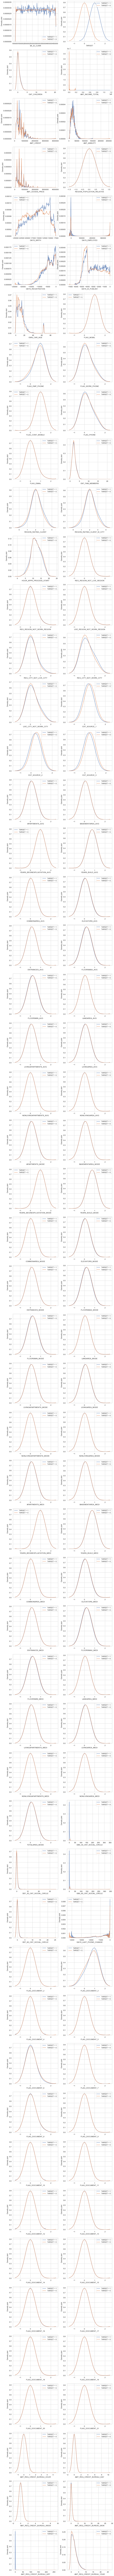

In [5]:
def plot_distribution(var):
    
    i = 0
    nrow = len(var) // 2
    t1 = train.loc[train['TARGET'] != 0]
    t0 = train.loc[train['TARGET'] == 0]
    
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow, 2, figsize=(12, 6*nrow))
    
    for feature in var:
        i += 1
        plt.subplot(nrow, 2, i)
        sns.kdeplot(t1[feature], bw=0.5, label='TARGET = 1')
        sns.kdeplot(t0[feature], bw=0.5, label='TARGET = 0')
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

numerical_feats = train.select_dtypes(include=[int, float]).columns
plot_distribution(numerical_feats);

In [6]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


numerical変数の欠損値は平均値で埋める。

In [7]:
train.fillna(train[numerical_feats].mean(), inplace=True)
test.fillna(train[numerical_feats].mean(), inplace=True)

In [8]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


### モデルの作成

- Random Forest

In [9]:
X = train[numerical_feats].drop(columns=['TARGET', 'SK_ID_CURR'])
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [10]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred_cv = forest.predict(X_test)

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


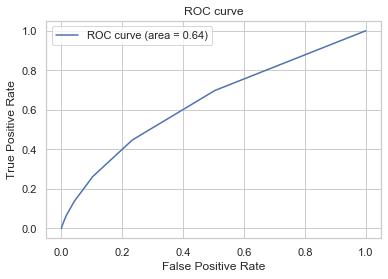

In [11]:
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_cv)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [12]:
importance = pd.DataFrame(forest.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
display(importance[:10])

,importance
EXT_SOURCE_2,0.081705
EXT_SOURCE_3,0.065033
DAYS_BIRTH,0.055487
DAYS_ID_PUBLISH,0.053822
DAYS_REGISTRATION,0.053798
AMT_ANNUITY,0.044639
DAYS_LAST_PHONE_CHANGE,0.043829
DAYS_EMPLOYED,0.043825
EXT_SOURCE_1,0.038811
AMT_INCOME_TOTAL,0.036169


- LightGBM

In [13]:
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
lgb_train = lgbm.Dataset(X_train, y_train)
lgb = lgbm.train(params, lgb_train)
y_pred = lgb.predict(X_test)

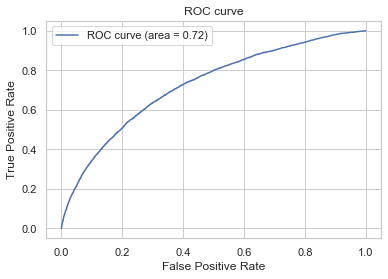

In [14]:
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [15]:
importance = pd.DataFrame(lgb.feature_importance(), index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
display(importance[:10])

,importance
EXT_SOURCE_2,719
EXT_SOURCE_1,685
EXT_SOURCE_3,510
DAYS_BIRTH,270
AMT_GOODS_PRICE,129
AMT_ANNUITY,118
AMT_CREDIT,109
FLAG_DOCUMENT_3,94
DAYS_EMPLOYED,83
AMT_REQ_CREDIT_BUREAU_DAY,53


### 提出ファイルの作成

In [16]:
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
lgb_data = lgbm.Dataset(X, y)
lgb = lgbm.train(params, lgb_data)
y_pred = lgb.predict(test.select_dtypes(include=['float64', 'int64']).drop(columns=['SK_ID_CURR']))

In [17]:
submit = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': y_pred})
submit.to_csv('submission_file.csv', index=False)

## 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

### 検証1
有用そうであった特徴'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYSBIRTH'を用いて検証を行う。

In [18]:
feats = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
X = train[feats]
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

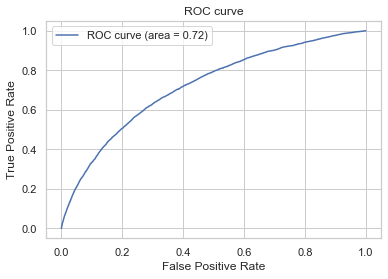

In [19]:
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
lgb_train = lgbm.Dataset(X_train, y_train)
lgb = lgbm.train(params, lgb_train)
y_pred = lgb.predict(X_test)

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
# ついでにAUCも
auc = metrics.auc(fpr, tpr)
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

全てのnumerical変数を使用したときと同等のスコアであった。

### 検証2
'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE'から特徴量を作成して検討する。

In [20]:
train['AGE'] = train['DAYS_BIRTH'] // (-365)
train['EXT_SOURCE_12'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2']
train['EXT_SOURCE_13'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_3']
train['EXT_SOURCE_23'] = train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']
train['EXT_SOURCE_123'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']
#train.drop(columns=['DAYS_BIRTH'], inplace=True)

test['AGE'] = test['DAYS_BIRTH'] // (-365)
test['EXT_SOURCE_12'] = test['EXT_SOURCE_1'] * test['EXT_SOURCE_2']
test['EXT_SOURCE_13'] = test['EXT_SOURCE_1'] * test['EXT_SOURCE_3']
test['EXT_SOURCE_23'] = test['EXT_SOURCE_2'] * test['EXT_SOURCE_3']
test['EXT_SOURCE_123'] = test['EXT_SOURCE_1'] * test['EXT_SOURCE_2'] * train['EXT_SOURCE_3']
#test.drop(columns=['DAYS_BIRTH'], inplace=True)

In [21]:
feats = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_12', 'EXT_SOURCE_13', 'EXT_SOURCE_23', 'EXT_SOURCE_123', 'AGE']
X = train[feats]
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

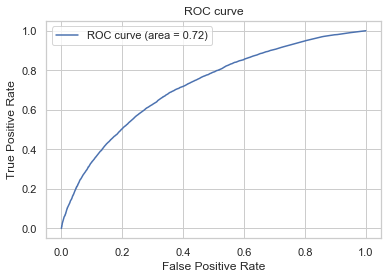

In [22]:
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
lgb_train = lgbm.Dataset(X_train, y_train)
lgb = lgbm.train(params, lgb_train)
y_pred = lgb.predict(X_test)

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
# ついでにAUCも
auc = metrics.auc(fpr, tpr)
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [23]:
importance = pd.DataFrame(lgb.feature_importance(), index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
display(importance[:10])

,importance
AGE,641
EXT_SOURCE_123,597
EXT_SOURCE_1,521
EXT_SOURCE_3,481
EXT_SOURCE_12,256
EXT_SOURCE_2,188
EXT_SOURCE_13,186
EXT_SOURCE_23,130


スコアはかわらなかったが、feature_importanceの値から新たに作成した'EXT_SOURCE_123'はtargetの特徴をより捉えていると考えられる。

### 検証3
category変数からダミー変数を作成。

In [24]:
categorical_feats = train.dtypes[train.dtypes == 'object'].index

In [25]:
#train[categorical_feats].nunique()

In [26]:
train_dummy = pd.get_dummies(train[categorical_feats], dummy_na=True, drop_first=True)
print(train_dummy.shape)
test_dummy = pd.get_dummies(test[categorical_feats], dummy_na=True, drop_first=True)
print(test_dummy.shape)

(307511, 140)
(48744, 137)


In [27]:
train = pd.concat([train, train_dummy], axis=1).drop(columns=categorical_feats)
print(train.shape)
test = pd.concat([test, test_dummy], axis=1).drop(columns=categorical_feats)
print(test.shape)

(307511, 251)
(48744, 247)


In [28]:
set(train.columns) ^ set(test.columns)

{'CODE_GENDER_XNA',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_INCOME_TYPE_Maternity leave',
 'TARGET'}

In [29]:
test['CODE_GENDER_XNA'] = 0
test['NAME_FAMILY_STATUS_Unknown'] = 0
test['NAME_INCOME_TYPE_Maternity leave'] = 0

In [30]:
X = train.drop(columns=numerical_feats, axis=1).drop(columns=['EXT_SOURCE_12', 'EXT_SOURCE_13', 'EXT_SOURCE_23', 'EXT_SOURCE_123', 'AGE'], axis=1)
y = train.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

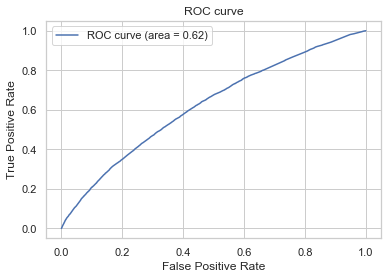

In [31]:
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
lgb_train = lgbm.Dataset(X_train, y_train)
lgb = lgbm.train(params, lgb_train)
y_pred = lgb.predict(X_test)

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
# ついでにAUCも
auc = metrics.auc(fpr, tpr)
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [32]:
importance = pd.DataFrame(lgb.feature_importance(), index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
display(importance[:10])

,importance
NAME_CONTRACT_TYPE_Revolving loans,436
FLAG_OWN_CAR_Y,304
NAME_FAMILY_STATUS_Married,228
EMERGENCYSTATE_MODE_nan,217
CODE_GENDER_M,209
NAME_EDUCATION_TYPE_Higher education,206
NAME_HOUSING_TYPE_House / apartment,105
NAME_HOUSING_TYPE_With parents,93
ORGANIZATION_TYPE_Transport: type 3,91
WALLSMATERIAL_MODE_Panel,89


スコア的にあまり良くない。

### 検証4
'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'EMERGENCYSTATE_MODE', 'CODE_GENDER'にHoldoutTSしてみる。

In [44]:
train = pd.read_csv('../week3/application_train.csv')
test = pd.read_csv('../week3/application_test.csv')

In [45]:
from sklearn.model_selection import KFold
target = train.TARGET
object_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'EMERGENCYSTATE_MODE']
for c in object_cols:
    data_tmp = pd.DataFrame({c: train[c], 'target': target})
    target_mean = data_tmp.groupby(c)['target'].mean()
    test[c] = test[c].map(target_mean)
    tmp = np.repeat(np.nan, train.shape[0])
    kf = KFold(n_splits=4, shuffle=True)
    for idx_1, idx_2 in kf.split(train):
        target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
        tmp[idx_2] = train[c].iloc[idx_2].map(target_mean)
    train[c] = tmp

In [46]:
feats = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'EMERGENCYSTATE_MODE']
X = train[feats]
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

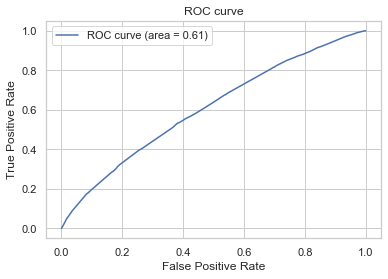

In [47]:
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
lgb_train = lgbm.Dataset(X_train, y_train)
lgb = lgbm.train(params, lgb_train)
y_pred = lgb.predict(X_test)

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
# ついでにAUCも
auc = metrics.auc(fpr, tpr)
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [48]:
importance = pd.DataFrame(lgb.feature_importance(), index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
display(importance[:10])

,importance
NAME_FAMILY_STATUS,705
NAME_CONTRACT_TYPE,678
EMERGENCYSTATE_MODE,550
FLAG_OWN_CAR,496
NAME_EDUCATION_TYPE,329
CODE_GENDER,242


ダミー変数を作成した検証3と同等のスコアであった。

### 検証5
全てのcategorical変数にTARGET ENCODINGしてみる。

In [39]:
train = pd.read_csv('../week3/application_train.csv')
test = pd.read_csv('../week3/application_test.csv')

In [40]:
target = train.TARGET
object_cols = train.select_dtypes(include=['object']).columns
for c in object_cols:
    data_tmp = pd.DataFrame({c: train[c], 'target': target})
    target_mean = data_tmp.groupby(c)['target'].mean()
    test[c] = test[c].map(target_mean)
    tmp = np.repeat(np.nan, train.shape[0])
    kf = KFold(n_splits=4, shuffle=True)
    for idx_1, idx_2 in kf.split(train):
        target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
        tmp[idx_2] = train[c].iloc[idx_2].map(target_mean)
    train[c] = tmp

In [41]:
X = train[object_cols]
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

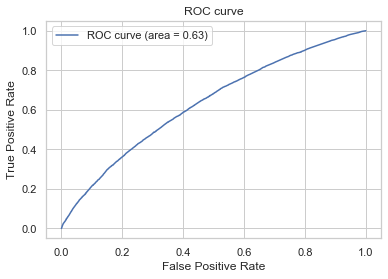

In [42]:
params = {
    'objective':'regression_l2',
    'metric':'auc',
    'learning_rate':0.01,
    'verbose':-1
}
lgb_train = lgbm.Dataset(X_train, y_train)
lgb = lgbm.train(params, lgb_train)
y_pred = lgb.predict(X_test)

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
# ついでにAUCも
auc = metrics.auc(fpr, tpr)
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [43]:
importance = pd.DataFrame(lgb.feature_importance(), index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
display(importance[:10])

,importance
ORGANIZATION_TYPE,413
CODE_GENDER,361
NAME_FAMILY_STATUS,343
FLAG_OWN_CAR,312
NAME_CONTRACT_TYPE,276
NAME_EDUCATION_TYPE,272
OCCUPATION_TYPE,222
WALLSMATERIAL_MODE,195
NAME_HOUSING_TYPE,173
EMERGENCYSTATE_MODE,140


検証4とスコアは同等。重要度の順序が変わった。  
特徴量間での重要度の差が小さくなっている様に見える。